# Dog Breed Identification
## Farhad Navid 

The goal of this analysis is to identify the various breed of dogs using Dog images provided in kaggle data set. 

This document is intended to go through the entire process step by step and at each step talk about the challenges faced during this project. 
* **Steps:**
1. Initiate Google Drive feature in Colab utilize cloud computing power
 * Discuss the Colab Feature to upload the data.
 * Discuss the alternative approaches.
2. Obtaining images. 
3. Preprocess the images. 
4. Create training data set X_train, y_train 
5. Create the X_test dataset
6. Prepare data to fit into a deep learning model
7. Build Model (Few Models are considered)
 * Simple CNN (Convolutional Neural Network)
 * Sequential CNN VGG style with 2 VGG block inception module architecture
 * Functional API CNN with inception architecture using BatchNormalization and Dropout
 
The Best Model will be selected to test against the test data.
A commentary for each step will be provided along with some visualization and summary through the process.  
in conclusion a summary commentary will be provided to discuss the challenges, weaknesses and opportunities for improvement in the models or the process.  


In [1]:
import matplotlib.pyplot as plt
import numpy 
import PIL
import pandas as pd
import os
import glob
import time
import numpy as np
import h5py

from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam

%matplotlib inline
K.set_image_dim_ordering( 'tf' )

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### *Note*
**Google drive feature in Colab was the initial consideration for this project.  Certain characteristic of the feature made it very time consuming. My being novice in utilizing the tool made it very time consuming for this project and alternative approaches was consider.**

This next block of code does represent the Directory structure of the data once the repository was selected.  In this instance the [**Crestle**](https://www.crestle.com/) (paid service) were utilized.  

In [2]:
# directory structure of the data

dpath_train = '/home/nbuser/train'      # Data path to training data set
dpath_test  = '/home/nbuser/test'       # Data path to test data set
dpath       = '/home/nbuser'
label_f     = '/home/nbuser/labels.csv' # Path to the label file 

## Uploading and Unpacking the data. 

In [3]:
# this block of code was used to un zip the uploaded files in the directory structured above. 
#os.chdir(dpath)
#!unzip train.zip  # unzips in it's own directory.
#!unzip test.zip   # unzips in it's own directory.
#!unzip labels.csv.zip

## Visualizing the image.

(375, 500, 3)


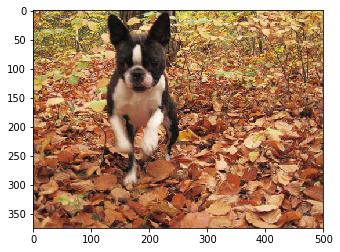

In [4]:
# sample image for debug purpose I will eliminate once sure the data set is correct. 
# Playing with the image and ploting will be use to compare with reduced size image.
os.chdir(dpath_train)
dogs = sorted(glob.glob('*.jpg'))
c0 = PIL.Image.open(dogs[0]) #read file path to an image, now c0 is a numpy image
cc0=np.array(c0)
print(cc0.shape)  # cc0 is the numpy array
plt.imshow(c0)    # vplotting the origenal sample image 

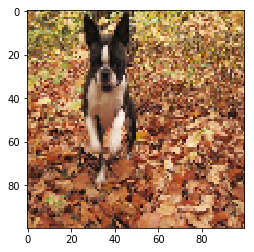

In [5]:
#cr0 is the reduced version of same image as above
cr0=c0.resize((100,100))
plt.imshow(cr0)    #the dog looks squashed, but seems ok and features are still there.  

## preprocessing of the data
* Define new image size.
* Create the X_train and y_train
* shuffle the train data sets.
* Normalize the data sets
* write the arrays to a file and upload

In [6]:
#### Preparing the input files Following loop will read the csv file for labels
os.chdir(dpath)
!ls
id_label= pd.read_csv(label_f)

os.chdir(dpath_train)    # need to be in train data dir
# these are the files in the train directory
dogs = sorted(glob.glob('*.jpg'))

im_W= 100
im_H= 100
# create X_train and y_train  with rescaling the images to 100X100 Now is hard coded but we should put them as variables (IM_W,im_H)
# rescale is the function we will call in for loop
def rescale(image):
    org_image = PIL.Image.open(image)
    trans_image = org_image.resize( (im_W, im_H) )
    tempAry = np.array(trans_image)
    tempAry = np.expand_dims(tempAry, axis = 0)    
    return tempAry

# declearing some varialbles for loop counter and book keeping
flag = 0
X_train=[]  #Training vector
y_train=[]
Count=0
for dog in dogs:
#     Count+=1
#     if Count==1000:  # debug just to see if it is working.
#         break
    if flag == 0:  #. this is used to handel the first picture. should come up with elegant situation.
        X_train=rescale(dog)
        flag=1
    else :   
        X_train=np.append(X_train,rescale(dog),axis=0) # creat a numpy array for tarining.  

#building y_train 
    newFlag = 0
    for x in range(id_label.shape[0]):
    
        if id_label.iloc[x,0] == dog[:-4]:       # Pilling off the ".jpg" from file name
            y_train.append(id_label.iloc[x,1]) 
            id_label.drop([x])
            newFlag = 1
            break
# The following can be added to the above loop to make sure indexing is working correctly and not missing anything. 
# Don't need it in reqular run 
#    if newFlag == 0:
#        y_train.append("Oops!") 
    

courses			 README.txt		    test.zip
examples		 sample_submission.csv.zip  train
Final_project_Dog.ipynb  submission.csv		    traindata.hdf5
labels.csv		 test			    train.zip
labels.csv.zip		 testdata.hdf5


## Data Shuffling 
**Now Shuffle the Training set just in case if they are sorted** 

In [7]:
# now shuffling training data. 
indx = np.array(list(range(len(dogs))))
np.random.shuffle(indx)
print(indx[:10]) #check the shuffling
#shuffle data
Xs_train = X_train[indx]

[2002 4985 5653 9526 8343 7908  246  570  823 8784]


### Final steps for preparing the X_train and y_train data.

In [8]:
# Now let's make sure we have all the unique dog names identified and chk the total number.

unique_Dog_Breed = []
for i in y_train:
    if i not in unique_Dog_Breed:
        unique_Dog_Breed.append(i)
    
unique_Dog_Breed.sort()   # Now sort the unique lable alphabatically. Next we need to count howmany unique label

count = 0
unique_Dog_Breed_Num = []   # integer assiciated with every unique Dog name

# with the next loops we are creating integers for each unique labels. in prepration of catagorizing the Y.

for i in unique_Dog_Breed:
    unique_Dog_Breed_Num.append([i, count])
    count += 1

for i in range(len(y_train)):
    for j in unique_Dog_Breed_Num:
        if y_train[i] == j[0]:
            y_train[i] = j[1]
            break

print("unique Dog Breed Numbers = ",len(unique_Dog_Breed_Num))
y_train = to_categorical(y_train)

Xs_train= Xs_train.astype( 'float32' )
Xs_train =Xs_train / 255   #normalize 

unique Dog Breed Numbers =  120


### Save the Train data incase we need to re run the models.

In [9]:
# now save to hdf5 

os.chdir(dpath)
with h5py.File('traindata.hdf5','w') as f:
    f.create_dataset('X', data=Xs_train)
    f.create_dataset('Y', data=y_train)

## Creating the test data from Test Directory
### Just print a sample make sure it looks ok for comparison.

10357


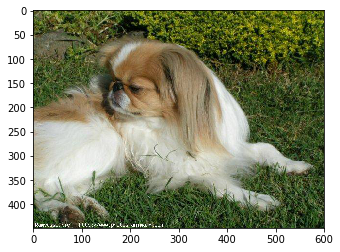

In [10]:
# now let's gt the test data prepared.
os.chdir(dpath_test)    # need to be in test data dir
# these are the files in the train directory
test_dogs = sorted(glob.glob('*.jpg'))
# chk to see the num of files in directory  can be eliminated once it is working
print(len(test_dogs))
c0_test = PIL.Image.open(test_dogs[0])
#test_dogs[:10]
plt.imshow(c0_test) # visualize a smaple image

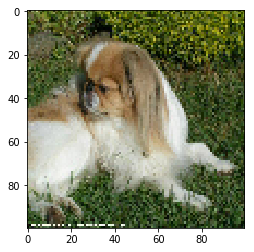

In [11]:
# Plot the resized just to make sure still looks OK.
cr0_test=c0_test.resize((im_W,im_H))
plt.imshow(cr0_test) #now the dogt looks squashed, but seems ok for this one. 

### Creating the X_test vector from the Test directory.

In [12]:
# Preparing the input files Following loop will read the csv file for labels
# os.chdir(dpath)
# id_label = pd.read_csv(label_f)

os.chdir(dpath_test)  # need to be in test data dir
# these are the files in the train directory
test_dogs = sorted(glob.glob('*.jpg'))

#create X_test and y_test  with rescaling the images to IM_W,im_H 
# rescale is the function we will call in for loop
def rescale(image):
    org_image = PIL.Image.open(image)
    new_image = org_image.resize((im_W, im_H))
    tstAry = np.array(new_image)
    tstAry = np.expand_dims(tstAry, axis=0)
    return tstAry


# declearing some varialbles for loop counter and book keeping
flag = 0
X_test = []  # Test vector

Count = 0
for w in test_dogs:
#     Count += 1
#     if Count == 1000:  # debug just to see if it is working.
#         break
    if flag == 0:  # . this is used to handel the first picture. should come up with elegant situation.
        X_test = rescale(w)
        flag = 1
    else:
        X_test = np.append(X_test, rescale(w), axis=0)  # creat a numpy array for test.  

X_test= X_test.astype( 'float32' )
X_test = X_test/255   #normalize 


In [13]:
os.chdir(dpath)
os.getcwd()
# now save to hdf5 (since it's huge I'd like to use hdf5)
# also hdf5 is a hierarchical data which lets you assign tags/groups or subgroups to your data
import h5py
with h5py.File('testdata.hdf5','w') as f:
    f.create_dataset('X', data=X_test)

print(X_test.shape,X_train.shape, y_train.shape)

(10357, 100, 100, 3) (10222, 100, 100, 3) (10222, 120)


## Loading the test and train files from repository.    

In [14]:
# load data
os.chdir(dpath)
#reading the file  that was created by input_prep file.
with h5py.File('traindata.hdf5','r') as f:
    X_train = f['X'][()] #the [()] means load all x_train data
    y_train = f['Y'][()] # Load all y_train data
    import h5py
with h5py.File('testdata.hdf5','r') as f:
    X_test = f['X'][()] #the [()] means load all data
    
print(X_train.shape,y_train.shape,X_test.shape)

(10222, 100, 100, 3) (10222, 120) (10357, 100, 100, 3)


## Models  
**Note:** 
* The BatchNormalization and Dropouts are attempted to be used in all models to make sure they all have same level playing field for comparison.  
* #### First Model is a 4 convolution CNN 
* #### Second is another Sequential model (VGG style)
* #### Third model is Functional API model with inception layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 100, 32)      96        
_________________________________________________________________
activation_7 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 50, 50, 64)        192       
__________

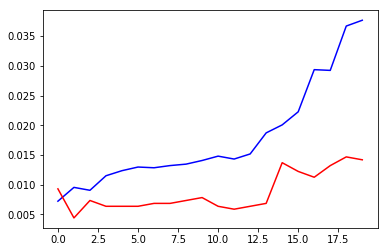

In [17]:
from keras.models import Sequential
# 4 Convolution layer CNN network
model_1 = Sequential()

model_1.add(Conv2D(32, 3 , padding='same',input_shape=(im_W, im_H, 3)))
model_1.add(BatchNormalization(axis=3, scale=False))
model_1.add(Activation("relu"))
model_1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model_1.add(Dropout(0.2))

#model_1.add(Conv2D(32, 3, padding='same'))
#model_1.add(BatchNormalization(axis=3, scale=False))
#model_1.add(Activation("relu"))
#model_1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#model_1.add(Dropout(0.2))

model_1.add(Conv2D(64, 3, padding='same'))
model_1.add(BatchNormalization(axis=3, scale=False))
model_1.add(Activation("relu"))
model_1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model_1.add(Dropout(0.2))

model_1.add(Conv2D(128, 3, padding='same'))
model_1.add(BatchNormalization(axis=3, scale=False))
model_1.add(Activation("relu"))
model_1.add(Flatten())
model_1.add(Dropout(0.5))

model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(120, activation='softmax'))
model_1.summary()

adam = Adam(lr=0.001)
model_1.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log_file = model_1.fit(X_train, y_train, validation_split=0.2, epochs= 20, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final predict the test files of the model
prediction_1 = model_1.predict(X_test)
#print("CNN Error: %.2f%%" % (100-scores[1]*100))

plt.plot(log_file.history['acc'],'b') 
plt.plot(log_file.history['val_acc'],'r')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 98, 98, 64)        1792      
_________________________________________________________________
batch_normalization_31 (Batc (None, 98, 98, 64)        256       
_________________________________________________________________
activation_64 (Activation)   (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_32 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
activation_65 (Activation)   (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 48, 48, 64)        0         
__________

1826.1456282138824  seconds


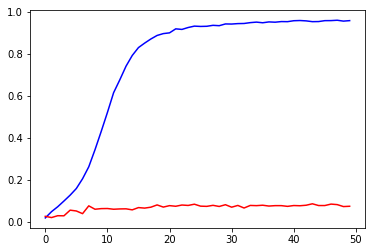

In [35]:
# Create a model with 4 convolutional layers (2 repeating VGG stype units) and 2 dense layers before the output
# Use Batch Normalization for every conv and dense layers and Droupout 

def model():
    model = Sequential()
    model.add(Conv2D(64, 3, input_shape=(im_W, im_H, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(120))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    return model

model_2 = model()
model_2.summary()
adam = Adam(lr=0.005)
model_2.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log_file = model_2.fit(X_train, y_train, validation_split=0.2, epochs= 50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final predict the test files of the model
prediction_2 = model_2.predict(X_test)

plt.plot(log_file.history['acc'],'b') 
plt.plot(log_file.history['val_acc'],'r')
plt.show()

In [15]:
# Inception layer with batchnormalization from our previous work, should have a better response. 
def inceptionWBN(x, n = 32):
    t1 = Conv2D(n, 1, padding='same')(x)  # first Tower a 1X1 Conv
    t1 = BatchNormalization()(t1)
    t1 = Activation('relu')(t1)
    t2 = Conv2D(n, 1, padding='same')(x)  # second Tower a 1X1 followed by 3X3 conv
    t2 = BatchNormalization()(t2)
    t2 = Activation('relu')(t2)
    t2 = Conv2D(n, 3, padding='same')(t2)
    t2 = BatchNormalization()(t2)
    t2 = Activation('relu')(t2)    
    t3 = Conv2D(n, 1, padding='same')(x)  # third Tower a 1X1 Followed by 5X5 vonv
    t3 = BatchNormalization()(t3)
    t3 = Activation('relu')(t3)    
    t3 = Conv2D(n, 5, padding='same')(t3)
    t3 = BatchNormalization()(t3)
    t3 = Activation('relu')(t3)  
    t4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x) # fourth Tower MaxPool 3X3 Followed by 1X1 conv   
    t4 = Conv2D(n, 1, padding='same')(t4)
    t4 = BatchNormalization()(t4)
    t4 = Activation('relu')(t4)     

    conc =  Concatenate(axis=-1)([t1,t2,t3,t4])  # Input to the next layer
    return conc

In [16]:
# I will be using the Functional API with 3 inception layer followed by a dense layer for the training.  
def model():
    inputs = Input(X_train.shape[1:])
    inp1 = inceptionWBN(inputs)
    mp1 = MaxPooling2D((2,2))(inp1)
    inp2 = inceptionWBN(mp1)
    mp2 = MaxPooling2D((2,2))(inp2) 
#    inp3 = inceptionWBN(mp1)
#    mp3 = MaxPooling2D((2,2))(inp3) 
    fltn = Flatten()(mp2)
    dns = Dense(256)(fltn) #. start with 64 and go up from there
    dns = BatchNormalization()(dns)
    dns = Activation('relu')(dns)
    out = Dense(120, activation='softmax')(dns)
    model = Model(inputs, out)
    return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 100, 100, 32) 128         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 100, 100, 32) 128         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 100, 100, 32) 128         conv2d_56[0][0]                  
__________________________________________________________________________________________________
batch_norm

Train on 8177 samples, validate on 2045 samples
Epoch 1/20
 - 49s - loss: 4.7580 - acc: 0.0303 - val_loss: 5.4773 - val_acc: 0.0323
Epoch 2/20
 - 45s - loss: 4.0141 - acc: 0.0989 - val_loss: 4.4882 - val_acc: 0.0513
Epoch 3/20
 - 45s - loss: 3.4570 - acc: 0.1914 - val_loss: 4.5730 - val_acc: 0.0704
Epoch 4/20
 - 45s - loss: 2.5224 - acc: 0.3902 - val_loss: 5.3008 - val_acc: 0.0655
Epoch 5/20
 - 45s - loss: 1.1130 - acc: 0.7373 - val_loss: 6.5909 - val_acc: 0.0557
Epoch 6/20
 - 45s - loss: 0.2463 - acc: 0.9570 - val_loss: 6.6572 - val_acc: 0.0509
Epoch 7/20
 - 45s - loss: 0.0424 - acc: 0.9974 - val_loss: 6.2435 - val_acc: 0.0660
Epoch 8/20
 - 45s - loss: 0.0168 - acc: 0.9990 - val_loss: 5.8801 - val_acc: 0.0773
Epoch 9/20
 - 45s - loss: 0.0124 - acc: 0.9991 - val_loss: 5.8125 - val_acc: 0.0880
Epoch 10/20
 - 45s - loss: 0.0101 - acc: 0.9993 - val_loss: 5.7119 - val_acc: 0.0866
Epoch 11/20
 - 45s - loss: 0.0105 - acc: 0.9993 - val_loss: 5.8481 - val_acc: 0.0934
Epoch 12/20
 - 45s - loss:

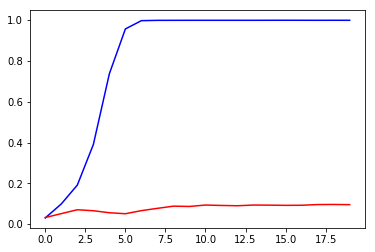

In [17]:
# Run the models to see the accuray
model_3 = model()
model_3.summary()
print(X_train.shape,y_train.shape,X_test.shape)
adam = Adam(lr=0.01)
model_3.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log_file = model_3.fit(X_train, y_train, validation_split=0.2, epochs= 20, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final predict the test files of the model
prediction_3 = model_3.predict(X_test)
#print("CNN Error: %.2f%%" % (100-scores[1]*100))

plt.plot(log_file.history['acc'],'b') 
plt.plot(log_file.history['val_acc'],'r')
plt.show()

In [19]:
prediction

array([[9.96303129e-07, 7.04222242e-04, 1.05334145e-07, ...,
        4.53925932e-05, 4.96713538e-03, 1.94656172e-06],
       [1.13428212e-06, 1.01241412e-05, 6.93005404e-08, ...,
        1.18420558e-05, 3.76698117e-05, 4.15600496e-08],
       [2.78639636e-04, 4.62540658e-03, 1.45980506e-04, ...,
        6.79078922e-02, 1.18075241e-05, 4.98616428e-04],
       ...,
       [6.56763499e-04, 1.52022069e-04, 6.72852993e-03, ...,
        5.63953677e-03, 9.45150589e-07, 3.23009491e-01],
       [9.61805381e-06, 1.36518327e-04, 7.82994448e-06, ...,
        6.01543070e-05, 7.29359017e-05, 7.31054926e-03],
       [3.65982078e-06, 9.89982300e-03, 1.77801601e-04, ...,
        1.10364403e-03, 8.50484967e-02, 4.62856769e-05]], dtype=float32)

## Creating the submission file in CSV format.

In [44]:
names = unique_Dog_Breed
rows = os.listdir(dpath +'/test')
os.chdir(dpath)
df = pd.DataFrame(prediction, index=rows, columns=names)
df.rename(columns={'index': 'img'}, inplace=True)
df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
9d591f86fdd00f9731dc51d68c7b6323.jpg,9.963031e-07,0.000704,1.053341e-07,0.000019,0.001015,1.286621e-07,2.543344e-06,0.000025,0.000044,2.656787e-04,...,0.000103,3.336046e-05,1.932227e-04,5.487259e-05,0.000004,0.001167,0.000018,0.000045,0.004967,1.946562e-06
6893b5ed882c7ae791e4a440f613a3f8.jpg,1.134282e-06,0.000010,6.930054e-08,0.000011,0.000082,3.173161e-08,8.690272e-06,0.000005,0.000013,5.474954e-07,...,0.000016,1.628623e-02,2.513495e-08,2.664325e-07,0.000001,0.000009,0.215687,0.000012,0.000038,4.156005e-08
2a1c95b9f131236b715df75ff815fd0b.jpg,2.786396e-04,0.004625,1.459805e-04,0.190624,0.003584,6.062565e-06,5.005667e-05,0.001121,0.000025,5.829281e-02,...,0.000132,6.105131e-03,1.605699e-03,6.783912e-06,0.001254,0.000105,0.000554,0.067908,0.000012,4.986164e-04
87e96ca57ae92a499e057debb62fc232.jpg,2.514467e-04,0.022263,1.180193e-03,0.000277,0.000959,4.392076e-06,1.673603e-02,0.000406,0.001522,2.333737e-05,...,0.001356,2.002962e-07,5.311599e-03,2.912785e-02,0.003575,0.000334,0.000278,0.032978,0.000013,6.388185e-06
d2da98041804728e98d85b9ee42571a3.jpg,2.685920e-05,0.000365,2.741268e-05,0.000013,0.008109,2.180807e-03,7.114688e-07,0.000001,0.000009,4.383926e-05,...,0.000095,6.538648e-04,5.926685e-07,6.879187e-07,0.005938,0.000101,0.007391,0.000081,0.000131,2.716689e-05


### Display just to check.

In [38]:
df.to_csv('submission.csv', index=True, header=True, sep=',')

courses			 README.txt		    test.zip
examples		 sample_submission.csv.zip  train
Final_project_Dog.ipynb  submission.csv		    traindata.hdf5
labels.csv		 test			    train.zip
labels.csv.zip		 testdata.hdf5


## **Ending Notes:**
The interesting point of this particular project was training set data.  there were total of 10222 dogs in the taring directory and 120 unique dog species. the histogram of this data set showed and average of 100 dogs per breed category.  this is too small of data.  The 3 model utilized in here are the basic one CNN, one two segment VGG and the third one is functional API model with inception module.  The best validation accuracy was with functional API at about 10% very low. the result does indicate a major overfilling in these models.  
**Following are some ideas for reducing overfitting:**
* Add more data
 * This was not possible limited by data set.  
* Use data augmentation
 * This is the most promising way to help this problem which requieres abit more work to add to this data set. 
* Use architectures that generalize well
* Add regularization (i.e dropout)
 * Various dropout was utilized and the best one was picked for each model
* Reduce architecture complexity. 
 * tried removing some layers but not much help in here.
 
**I was able to increase the validation accuracy form couple of percent to about 18% the high-water mark. Next, I will try the input augmentation to see the improvement on the prediction.  This will require a bit of work.**  